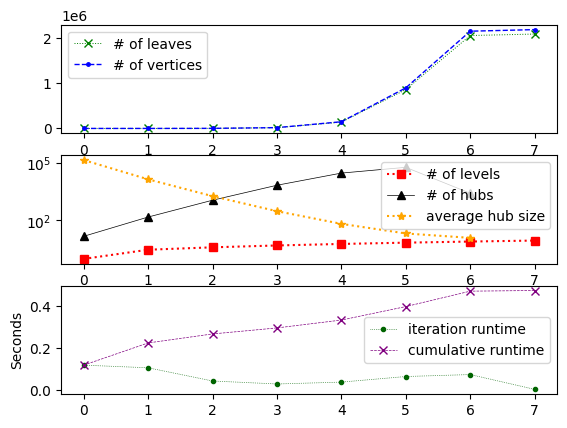

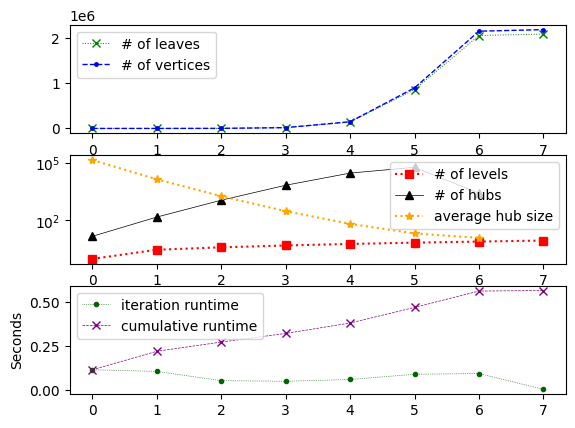

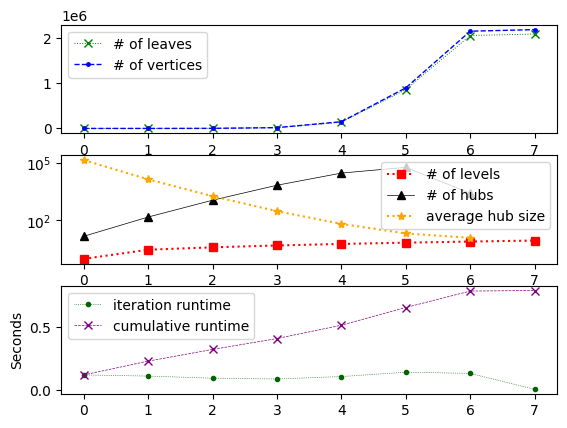

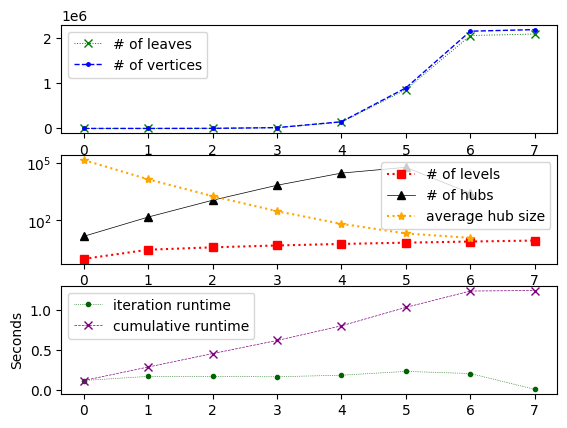

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

BuildInfo = namedtuple("BuildInfo", ["total_time", "num_hubs", "num_leaves", "num_levels", "num_vertices", "iter_times"])
GraphInfo = namedtuple("GraphInfo", ["total_time", "num_edges", "num_vertices", "dist_comps", "thread_edges", "thread_queries"])
ParameterInfo = namedtuple("ParameterInfo", ["min_hub_size", "num_threads", "radius", "split_ratio", "switch_percent"])
PointsInfo = namedtuple("PointsInfo", ["dimension", "float_size", "filename", "size"])

def parse_build_info(build_info):
    total_time = build_info["total_time"]
    iterations = build_info["iterations"]
    num_hubs = np.array([it["num_hubs"] for it in iterations])
    num_leaves = np.array([it["num_leaves"] for it in iterations])
    num_levels = np.array([it["num_levels"] for it in iterations])
    num_vertices = np.array([it["num_vertices"] for it in iterations])
    iter_times = np.array([it["time"] for it in iterations])
    return BuildInfo(total_time=total_time, num_hubs=num_hubs, num_leaves=num_leaves, num_levels=num_levels, num_vertices=num_vertices, iter_times=iter_times)

def parse_graph_info(graph_info):
    total_time = graph_info["total_time"]
    graph_threads = sorted(graph_info["graph_threads"], key=lambda o: o["thread_id"])
    num_edges = graph_info["num_edges"]
    num_vertices = graph_info["num_vertices"]
    dist_comps = np.array([t["thread_dist_comps"] for t in graph_threads])
    thread_edges = np.array([t["thread_edges"] for t in graph_threads])
    thread_queries = np.array([t["thread_queries"] for t in graph_threads])
    thread_times = np.array([t["thread_time"] for t in graph_threads])
    return GraphInfo(total_time=total_time, num_edges=num_edges, num_vertices=num_vertices, dist_comps=dist_comps, thread_edges=thread_edges, thread_queries=thread_queries)

def parse_parameter_info(parameter_info):
    return ParameterInfo(min_hub_size=parameter_info["min_hub_size"], num_threads=parameter_info["num_threads"], radius=parameter_info["radius"], split_ratio=parameter_info["split_ratio"], switch_percent=parameter_info["switch_percent"])

def parse_points_info(points_info):
    return PointsInfo(dimension=points_info["dimension"], float_size=points_info["float_size"], filename=points_info["filename"], size=points_info["size"])

def get_points_info_string(pi):
    return f"{pi.dimension}d.{pi.float_size}fp.{pi.size}size"

def get_params_info_string(pi):
    return f"{pi.min_hub_size}l.{pi.num_threads}t.{pi.radius:.2f}r"

def plot_build_iter_info(exp):
    build_info = parse_build_info(exp["build_info"])
    graph_info = parse_graph_info(exp["graph_info"])
    parameter_info = parse_parameter_info(exp["parameter_info"])
    points_info = parse_points_info(exp["points_info"])

    fig, axs = plt.subplots(3)

    cumulative_times = np.add.accumulate(build_info.iter_times)
    xdata = np.array(range(len(build_info.num_hubs)))
    avg_hub_sizes = (points_info.size - build_info.num_leaves)[:-1] / (build_info.num_hubs)[:-1]

    axs[0].plot(xdata, build_info.num_leaves, ':x', linewidth=0.7, color='green', label="# of leaves")
    axs[0].plot(xdata, build_info.num_vertices, '--o', markersize=2.5, linewidth=1.0, color='blue', label="# of vertices")
    axs[0].legend()

    axs[1].plot(xdata, build_info.num_levels, ':s', color='red', label="# of levels")
    axs[1].plot(xdata[:-1], build_info.num_hubs[:-1], '-^', linewidth=0.5, color='black', label="# of hubs")
    axs[1].plot(xdata[:-1], avg_hub_sizes, ':*', color='orange', label="average hub size")
    axs[1].set_yscale("log")
    axs[1].legend()

    axs[2].plot(xdata, build_info.iter_times, ':.', linewidth=0.5, color='darkgreen', label="iteration runtime")
    axs[2].plot(xdata, cumulative_times, '--x', linewidth=0.5, color='purple', label="cumulative runtime")
    axs[2].set_ylabel("Seconds")
    axs[2].legend()

    plt.show()
    fig.savefig(f"build_iter_info.{get_points_info_string(points_info)}.{get_params_info_string(parameter_info)}.pdf")

experiments = json.load(open("results.json", "r"))["experiments"]

for exp in experiments: plot_build_iter_info(exp)


In [4]:
experiments

[{'build_info': {'iterations': [{'iter': 1,
     'num_hubs': 15,
     'num_leaves': 0,
     'num_levels': 1,
     'num_vertices': 1,
     'time': 0.11855697631835938},
    {'iter': 2,
     'num_hubs': 151,
     'num_leaves': 57,
     'num_levels': 3,
     'num_vertices': 73,
     'time': 0.10597801208496094},
    {'iter': 3,
     'num_hubs': 1135,
     'num_leaves': 1637,
     'num_levels': 4,
     'num_vertices': 1804,
     'time': 0.04294395446777344},
    {'iter': 4,
     'num_hubs': 6829,
     'num_leaves': 16846,
     'num_levels': 5,
     'num_vertices': 18148,
     'time': 0.02869415283203125},
    {'iter': 5,
     'num_hubs': 29333,
     'num_leaves': 140535,
     'num_levels': 6,
     'num_vertices': 148666,
     'time': 0.03755497932434082},
    {'iter': 6,
     'num_hubs': 58534,
     'num_leaves': 863746,
     'num_levels': 7,
     'num_vertices': 901210,
     'time': 0.0642690658569336},
    {'iter': 7,
     'num_hubs': 2613,
     'num_leaves': 2064602,
     'num_levels': 

In [5]:
exp = experiments[0]

In [6]:
exp


{'build_info': {'iterations': [{'iter': 1,
    'num_hubs': 15,
    'num_leaves': 0,
    'num_levels': 1,
    'num_vertices': 1,
    'time': 0.11855697631835938},
   {'iter': 2,
    'num_hubs': 151,
    'num_leaves': 57,
    'num_levels': 3,
    'num_vertices': 73,
    'time': 0.10597801208496094},
   {'iter': 3,
    'num_hubs': 1135,
    'num_leaves': 1637,
    'num_levels': 4,
    'num_vertices': 1804,
    'time': 0.04294395446777344},
   {'iter': 4,
    'num_hubs': 6829,
    'num_leaves': 16846,
    'num_levels': 5,
    'num_vertices': 18148,
    'time': 0.02869415283203125},
   {'iter': 5,
    'num_hubs': 29333,
    'num_leaves': 140535,
    'num_levels': 6,
    'num_vertices': 148666,
    'time': 0.03755497932434082},
   {'iter': 6,
    'num_hubs': 58534,
    'num_leaves': 863746,
    'num_levels': 7,
    'num_vertices': 901210,
    'time': 0.0642690658569336},
   {'iter': 7,
    'num_hubs': 2613,
    'num_leaves': 2064602,
    'num_levels': 8,
    'num_vertices': 2160600,
    'tim